In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from pysindy import SINDy
from sklearn.preprocessing import StandardScaler
from pysindy.optimizers import STLSQ
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold 
from pysindy.feature_library import PolynomialLibrary, FourierLibrary, GeneralizedLibrary

# Model agnostic 
from typing import Optional, List, Callable, Dict, Any, List
from pathlib import Path
from itertools import islice
from utils import ChiefBldr  # custom model for data handling/model trianing

# Model specific 
from typing import Optional, List 

This version of Feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at https://abzu.ai/eula.

In [5]:
# Get the directory this file lives in
nb_dir = Path.cwd() # notebook directory
project_root = nb_dir.parents[0] # project directory
data_path = project_root / "datasets" / "processed_well_data.csv"

includ_cols = ['Dia', 'Dev(deg)','Area (m2)', 'z','GasDens','LiquidDens', 'P/T','friction_factor', 'critical_film_thickness']
D = ChiefBldr(path=data_path, includ_cols=includ_cols, test_size=0.20)

In [6]:
def sindy(
        hparams: Dict[str,Any]
):      
        # partition dict by method
        hparams_opt = dict(list(hparams.items())[:2])
        hparams_poly = dict(list(hparams.items())[-2:-1])
        hparams_fourier = dict(list(hparams.items())[-1:])
        
        # Define optimizer for SINDy
        hparams_opt = dict(islice(hparams.items(), 2))
        optimizer = STLSQ(
        max_iter=10000,
        normalize_columns=True,
        **hparams_opt,
        )
        # specify feature lib
        poly_library = PolynomialLibrary(**hparams_poly)
        fourier_library = FourierLibrary(**hparams_fourier)
        lib = GeneralizedLibrary([poly_library, fourier_library])
        model = SINDy(optimizer=optimizer, feature_library=lib)

        return model 

hparam_grid = {
    'alpha': np.logspace(-4, 0.25, 10),      
    'threshold': np.logspace(-4, -1, 10),  
    'degree': [1, 2, 3, 4],
    'n_frequencies': [1, 2, 3, 4]
}

# train model and optimize hyperparameters via grid search 
trained_model = D.evolv_model(build_model=sindy, hparam_grid=hparam_grid, k_folds=5)


Training model and optimizing hyperparameters via k-fold CV...
Done. Best score = 0.7463458110516934
Best hyperparameters: {'alpha': 1.7782794100389228, 'threshold': 0.1, 'degree': 2, 'n_frequencies': 2}
Retraining optimized model on full training set
Training set score: 0.7650602409638554
Test set score: 0.6666666666666666


In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(D.y_train, D.y_train_pred, label='Train', color='green', alpha=0.7)
plt.plot([D.y.min(), D.y.max()], [D.y.min(), D.y.max()], 'r--')
plt.xlabel("Actual Y")
plt.ylabel("Predicted Y")
plt.title("Train Performance")
plt.legend()


plt.tight_layout()
plt.show()


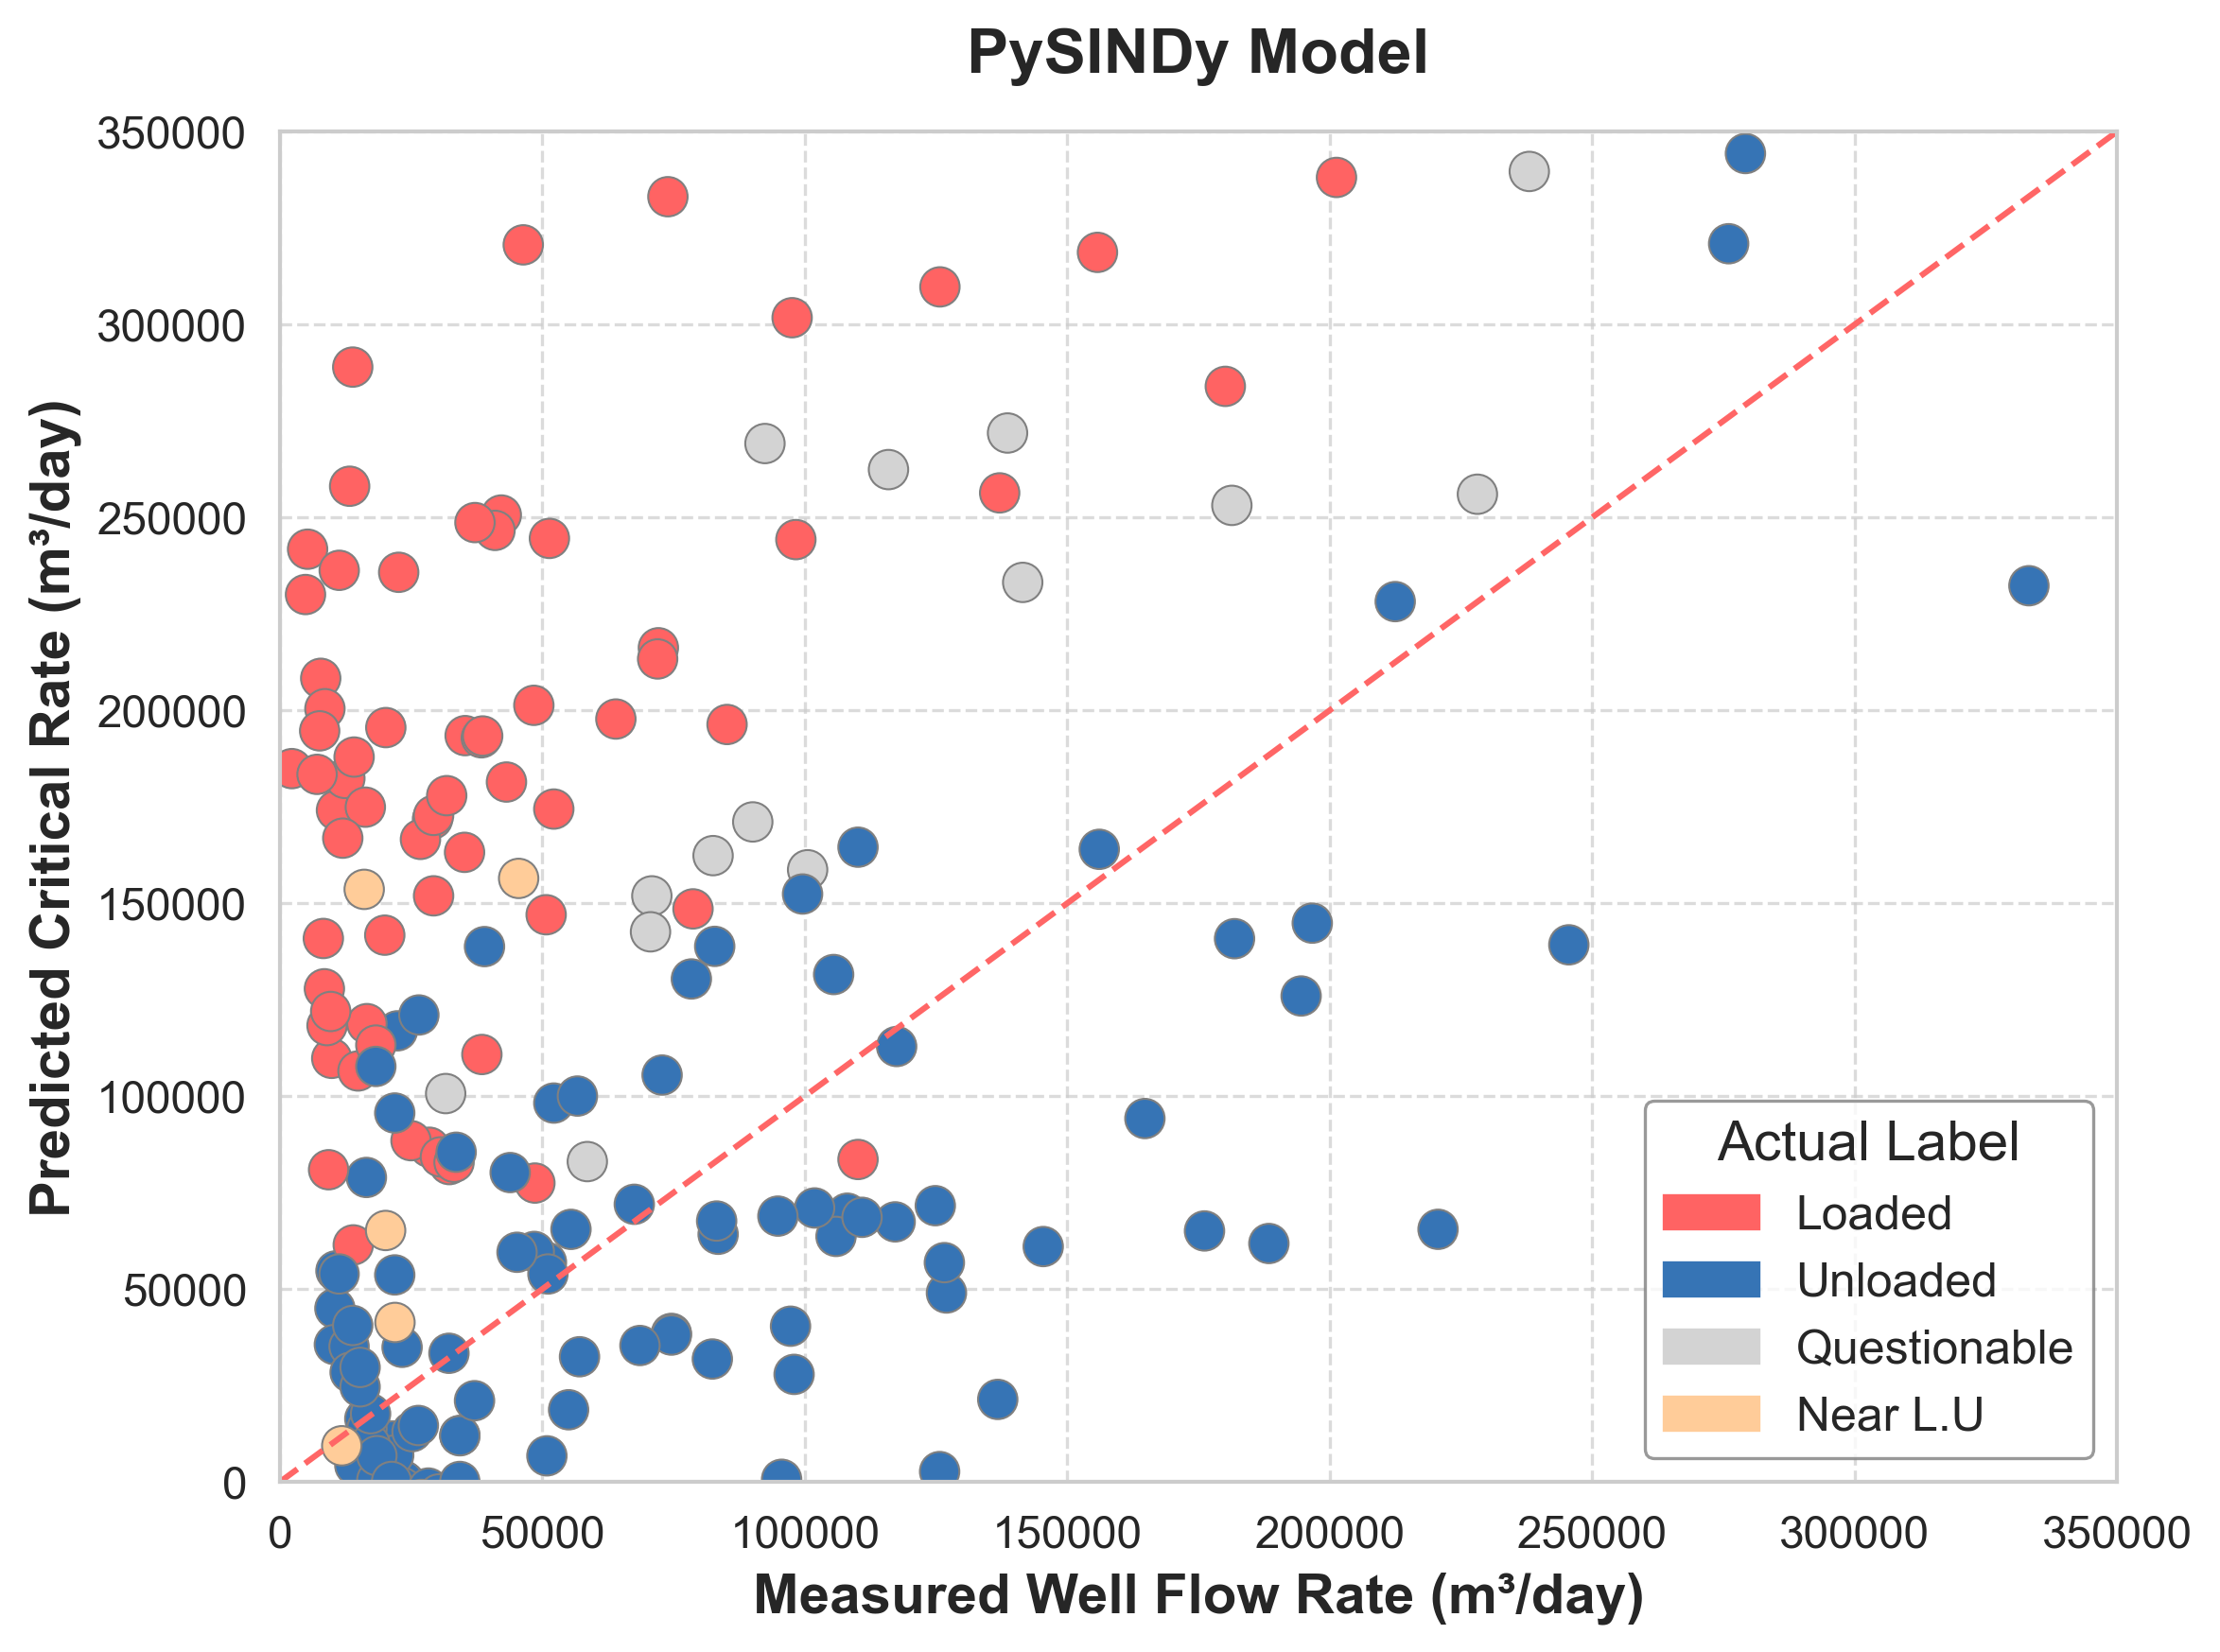

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

# Set publication-friendly plotting settings
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Arial'  # Publication-friendly font
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Define a light, publication-friendly color palette without green
color_map = {
    'Loaded': '#FF6363',  # Light red
    'Unloaded': '#3674B5',  # Light purple
    'Questionable': '#D3D3D3',  # Light orange
    'Near L.U': '#FFCC99'  # Light blue
}

colors = D.status_col.map(color_map).fillna('#D3D3D3')  # Light gray for missing values
y_pred_scaled = trained_model.predict(D.X_scaled)
y_pred = D.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
plt.figure(figsize=(8, 6), dpi=300)
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, font='Arial')
plt.scatter(D.gsflow , y_pred, c=colors, alpha=1, s=100, edgecolors="gray", linewidth=0.5)
plt.plot([0, 350000], [0, 350000], '--', color='#FF6666', linewidth=1.5)  # Light red dashed line
plt.title("PySINDy Model", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Measured Well Flow Rate (m³/day)", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Critical Rate (m³/day)", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 350000)
plt.ylim(0, 350000)
legend_patches = [mpatches.Patch(color=color, label=status) for status, color in color_map.items()]
plt.legend(handles=legend_patches, title='Actual Label', fontsize=12, title_fontsize=14, 
           loc='best', frameon=True, edgecolor='gray')
plt.tight_layout()
plt.savefig("pysindy_scatter.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()